<a href="https://colab.research.google.com/github/abialbon/pytorch-udacity-scholarship/blob/master/PyTorch/Validation_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercise on Validation and Accuracy

In [2]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision


tcmalloc: large alloc 1073750016 bytes == 0x59310000 @  0x7f40b8f192a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [3]:
import torch
from torchvision import transforms, datasets

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

training_data = datasets.FashionMNIST('~/fasion', train=True, download=True, transform=transform)
trainset = torch.utils.data.DataLoader(training_data, shuffle=True, batch_size=64)

testing_data = datasets.FashionMNIST('~/fasion', train=True, download=False, transform=transform)
testset = torch.utils.data.DataLoader(testing_data, shuffle=True, batch_size=64)

Processing...
Done!


In [18]:
from torch import nn
import torch.nn.functional as F
from torch import optim

class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 64)
    self.fc3 = nn.Linear(64, 10)
    
    self.ReLU = nn.ReLU()
    self.LogSoftmax = nn.LogSoftmax(dim=1)
    

  def forward(self, x):
    x = self.fc1(x)
    x = self.ReLU(x)
    x = self.fc2(x)
    x = self.ReLU(x)
    x = self.fc3(x)
    x = self.LogSoftmax(x)
    
    return x
  
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.010)
print(model)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (ReLU): ReLU()
  (LogSoftmax): LogSoftmax()
)


In [19]:
training_loss = []
testing_loss = []

epochs = 20

for e in range(epochs):
  
  #Training the model
  running_train_loss = 0
  for images, labels in trainset:
    images = images.view(images.shape[0], 784)
    
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    running_train_loss += loss.item()
    
    loss.backward()
    optimizer.step()
  else:
    training_loss.append(running_train_loss)
    print('Epoch: {} ######'.format(e + 1))
    print('Training loss: {:.2f}'.format(running_train_loss))
    
    # Validating the model from testset
    with torch.no_grad():
      running_test_loss = 0
      for images, labels in testset:
        images = images.view(images.shape[0], 784)

        output = model.forward(images)
        loss = criterion(output, labels)
        running_test_loss += loss.item()
      else:
        testing_loss.append(running_test_loss)
        print('Testling loss: {:.2f}'.format(running_test_loss))
      

Epoch: 1 ######
Training loss: 510.33
Testling loss: 444.59
Epoch: 2 ######
Training loss: 418.09
Testling loss: 381.27
Epoch: 3 ######
Training loss: 389.77
Testling loss: 393.73
Epoch: 4 ######
Training loss: 379.85
Testling loss: 355.87
Epoch: 5 ######
Training loss: 375.22
Testling loss: 358.67
Epoch: 6 ######
Training loss: 361.62
Testling loss: 393.44
Epoch: 7 ######
Training loss: 358.81
Testling loss: 343.88
Epoch: 8 ######
Training loss: 342.09
Testling loss: 332.96
Epoch: 9 ######
Training loss: 343.28
Testling loss: 318.03
Epoch: 10 ######
Training loss: 342.51
Testling loss: 329.65
Epoch: 11 ######
Training loss: 331.38
Testling loss: 305.49
Epoch: 12 ######
Training loss: 334.68
Testling loss: 320.84
Epoch: 13 ######
Training loss: 336.49
Testling loss: 356.88
Epoch: 14 ######
Training loss: 331.11
Testling loss: 303.55
Epoch: 15 ######
Training loss: 321.23
Testling loss: 343.78
Epoch: 16 ######
Training loss: 322.69
Testling loss: 288.70
Epoch: 17 ######
Training loss: 3

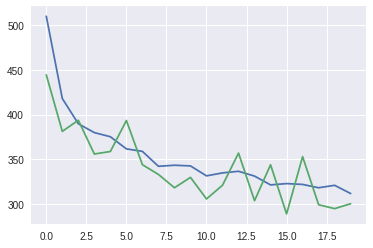

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(training_loss)
plt.plot(testing_loss)

In [37]:
import numpy as np

# Calculating the accuracy
with torch.no_grad():
  accuracy = np.array([])
  for images, labels in trainset:
    images = images.view(images.shape[0], 784)
    
    output = model.forward(images)
    ps = torch.exp(output)
    
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    equals = equals.type(torch.FloatTensor)
    accuracy = np.append(accuracy, torch.mean(equals).item())
  else:
    print('The accuracy is: {:.2f}%'.format(accuracy.mean()*100))

The accuracy is: 88.55%
